In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, ParticleFile, Variable, Field, ParcelsRandom
from parcels.application_kernels.TEOSseawaterdensity import PolyTEOS10_bsq
from datetime import timedelta as delta
import numpy as np
from glob import glob
import xarray as xr
import math

seed = 123
ParcelsRandom.seed(seed)

#------ Choose ------:
simdays = 20
secsdt = 60 #30
hrsoutdt = 6

INFO: Compiled ParcelsRandom ==> /tmp/parcels-265811/libparcels_random_e40ae50c-c4a1-47b7-b0d2-b5a661b57667.so


In [2]:
region = 'EqPac'
yr = '2004'
mon ='01'

In [3]:
class plastic_particle(JITParticle): #ScipyParticle): #
    u = Variable('u', dtype=np.float32,to_write=False)
    v = Variable('v', dtype=np.float32,to_write=False)
    w = Variable('w', dtype=np.float32,to_write=False)
    w_adv = Variable('w_adv', dtype=np.float32,to_write=False)
    temp = Variable('temp',dtype=np.float32,to_write=False)
    density = Variable('density',dtype=np.float32,to_write=False)
    mld = Variable('mld',dtype=np.float32,to_write=True)
    w_m = Variable('w_m',dtype=np.float32,to_write=True)
    vs_init = Variable('vs_init',dtype=np.float32,to_write=False)
    vs = Variable('vs',dtype=np.float32,to_write=False)
    r_pl = Variable('r_pl',dtype=np.float32,to_write='once')
    rho_pl = Variable('rho_pl',dtype=np.float32,to_write='once')
    rho_tot = Variable('rho_tot',dtype=np.float32,to_write=False)
    r_tot = Variable('r_tot',dtype=np.float32,to_write=True)
    delta_rho = Variable('delta_rho',dtype=np.float32,to_write=False)
    kin_visc = Variable('kin_visc',dtype=np.float32,to_write=False)
    sw_visc = Variable('sw_visc',dtype=np.float32,to_write=False)
    a = Variable('a',dtype=np.float32,to_write=True)
    rho_bf = Variable('rho_bf',dtype=np.float32,to_write=False)
    d_phy = Variable('d_phy',dtype=np.float32,to_write=False)
    Gro = Variable('Gro',dtype=np.float32,to_write=False)
    Graz = Variable('Graz',dtype=np.float32,to_write=False)
    Sen = Variable('Sen',dtype=np.float32,to_write=False)
    Resp = Variable('Resp',dtype=np.float32,to_write=False)
    Doc = Variable('Doc',dtype=np.float32,to_write=False)
    a_coll = Variable('a_coll', dtype=np.float32, to_write=True)
    a_gro = Variable('a_gro',dtype=np.float32,to_write=True)
    a_graz = Variable('a_graz',dtype=np.float32,to_write=True)
    a_sen = Variable('a_sen',dtype=np.float32,to_write=True)
    a_resp = Variable('a_resp',dtype=np.float32,to_write=True)
    a_doc = Variable('a_doc',dtype=np.float32,to_write=True)

def AdvectionRK4_3D(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration including vertical velocity.
    Function needs to be converted to Kernel object before execution"""
    (u1, v1, w1) = fieldset.UVW[particle]
    lon1 = particle.lon + u1*.5*particle.dt
    lat1 = particle.lat + v1*.5*particle.dt
    dep1 = particle.depth + w1*.5*particle.dt
    if dep1 > 5.:
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1, particle]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt
        if dep2 > 5.:
            (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2, particle]
            lon3 = particle.lon + u3*particle.dt
            lat3 = particle.lat + v3*particle.dt
            dep3 = particle.depth + w3*particle.dt
            if dep2 >5.:
                (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3, particle]
                if particle.depth + (w1 + 2*w2 + 2*w3 + w4) / 6. * particle.dt > 5.:
                    particle.depth += (w1 + 2*w2 + 2*w3 + w4) / 6. * particle.dt
                else:
                    particle.depth = 5.
            else:
                particle.depth = 5.
        else:particle.depth = 5.
    else:
        particle.depth = 5.
    
    particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    
    
def Profiles(particle, fieldset, time):
    particle.temp = fieldset.cons_temperature[time, particle.depth,particle.lat,particle.lon]
    particle.d_phy= fieldset.d_phy[time, particle.depth,particle.lat,particle.lon]
    particle.Gro = fieldset.gro[time, particle.depth,particle.lat,particle.lon]
    particle.Graz = fieldset.graz[time, particle.depth,particle.lat,particle.lon]
    particle.Sen = fieldset.sen[time, particle.depth,particle.lat,particle.lon]
    particle.Resp = fieldset.resp[time, particle.depth,particle.lat,particle.lon]
    particle.Doc = fieldset.DOC[time, particle.depth,particle.lat,particle.lon]

    mu_w = 4.2844E-5 + (1/((0.157*(particle.temp + 64.993)**2)-91.296))
    A = 1.541 + 1.998E-2*particle.temp - 9.52E-5*particle.temp**2
    B = 7.974 - 7.561E-2*particle.temp + 4.724E-4*particle.temp**2
    S_sw = fieldset.abs_salinity[time, particle.depth, particle.lat, particle.lon]/1000
    particle.sw_visc = mu_w*(1 + A*S_sw + B*S_sw**2)
    particle.kin_visc = particle.sw_visc/particle.density
    particle.w_adv = fieldset.W[time,particle.depth,particle.lat,particle.lon]
    mld = fieldset.mldep[time, particle.depth, particle.lat, particle.lon]
    particle.mld = particle.depth/mld

def uniform_release(n_locs, n_particles_per_bin, n_bins, e_max=-3, e_min=-5):
    '''
    Create a set of particle radii with a fixed amount of particles per bin for a given number of release locations.
    The bins are spaced logarithmically.

    :param n_locs: number of release locations
    :param n_particles_per_bin: number of particles per bin:
    :param n_bins: number of bins between 1E-e_max and 1E-e_min
    :param e_max: Exponent of the largest particle. -3 -> 1E-3 m = 1 mm
    :param e_min: Exponent of the smallest particle. -6 -> 1E-6 = 1 um
    '''
    sizes = np.logspace(e_min, e_max, n_bins)
    location_r_pls = np.repeat(sizes, n_particles_per_bin)
    r_pls = np.tile(location_r_pls, [n_locs,1])
    return r_pls

def DeleteParticle(particle, fieldset, time):
    """Kernel for deleting particles if they are out of bounds."""
    print('particle is deleted out of bounds at lon = '+str(particle.lon)+', lat ='+str(particle.lat)+', depth ='+str(particle.depth))
    particle.delete()
    
def DeleteSurface(particle, fieldset, time):
    """Kernel for deleting particles if they are out of bounds."""
    print('particle is deleted through surface at depth = '+str(particle.depth))
    particle.delete()

def DeleteParticleInterp(particle, fieldset, time):
    """Kernel for deleting particles if they are out of bounds."""
    print('particle is deleted due to an interpolation error at lon = '+str(particle.lon)+', lat ='+str(particle.lat)+', depth ='+str(particle.depth))
    particle.delete()

def markov_0_KPP_reflect(particle, fieldset, time):
    """
    If a particle tries to cross the boundary, then it is reflected back
    Author: Victor Onink
    Adapted 1D -> 3D
    Adapted for NASA_GISS modelE using 'kvert'
    """
    K_z = fieldset.kz[time, particle.depth, particle.lat, particle.lon]
    # According to Ross & Sharples (2004), first the deterministic part of equation 1
#     deterministic = dK_z_p * particle.dt
    deterministic = 0.

    # The random walk component
    R = ParcelsRandom.uniform(-1., 1.) * math.sqrt(math.fabs(particle.dt) * 3)
    bz = math.sqrt(2 * K_z)

    # Total movement
    w_m_step = deterministic + R * bz
    particle.w_m = w_m_step/particle.dt

    # The ocean surface acts as a lid off of which the plastic bounces if tries to cross the ocean surface
    potential = particle.depth + w_m_step
    if potential < 5.:
        particle.depth = 5. + (5. - potential)
    else:
        particle.depth = potential

def NASA_GISS(particle,fieldset,time):
    """
    Kernel to compute the vertical velocity (Vs) of particles due to changes in ambient algal concentrations, growth and death of attached algae based on Kooi et al. 2017 model
    """
    # ------ Constants and algal properties -----
    g = fieldset.G            # gravitational acceleration [m s-2]
    k = fieldset.K            # Boltzmann constant [m2 kg d-2 K-1] now [s-2] (=1.3804E-23)
    rho_fr = fieldset.Rho_fr  # frustule density [g m-3]
    v_a = fieldset.V_a        # Volume of 1 algal cell [m-3]
    a_diss = fieldset.Diss    # dissolution rate [s-1]
    gamma = fieldset.Gamma    # shear [s-1]

    # ------ Profiles from MEDUSA or Kooi theoretical profiles -----
    z = particle.depth  # [m]
    t = particle.temp  # [oC]
    sw_visc = particle.sw_visc  # [kg m-1 s-1]
    kin_visc = particle.kin_visc  # [m2 s-1]
    rho_sw = particle.density  # [kg m-3]
    a = particle.a  # [no. m-2]
    vs = particle.vs  # [m s-1]

    #------ Nitrogen to cell ratios for ambient algal concentrations ('aa') and algal growth ('mu_aa') from NEMO output (no longer using N:C:AA (Redfield ratio), directly N:AA from Menden-Deuer and Lessard 2000)
    med_N2cell = 356.04e-09 # [mgN cell-1] median value is used below (as done in Kooi et al. 2017)
    med_chlcell = 1e-08     # [mgChl cell-1] 
    wt_N = fieldset.Wt_N    # atomic weight of 1 mol of N = 14.007 g
    wt_Si = fieldset.Wt_Si  # atomic weight of 1 mol of Si = 28.0855 g

    #------ Ambient algal concentration from MEDUSA's non-diatom + diatom phytoplankton
    d = particle.d_phy                  # [mg chl m-3] diatom concentration that attaches to plastic particles
    
    d2 = d/med_N2cell                   # conversion from [mg chl m-3] to [no. m-3]

    ad = d2                            # [no m-3] ambient diatoms
    
    #------ Primary productivity (algal growth) from MEDUSA TPP3 (no longer condition of only above euphotic zone, since not much diff in results)
    a_gro = particle.Gro              # [mg chl m-3 s-1]
    mu_n = a_gro/med_chlcell          # conversion from [mg chl m-3 s-1] to [no. m-3 s-1]
    mu_n2 = mu_n/ad                   # conversion from [no. m-3 s-1] to [s-1]

    if mu_n2<0.:
        mu_ad = 0.
    elif mu_n2>1.85:
        mu_ad = 1.85           # [s-1] maximum growth rate
    else:
        mu_ad = mu_n2          # [s-1]

    #------ Grazing -----
    gr0 = particle.Graz         # [mg chl m-3 s-1]
    gr_n = gr0/med_chlcell      # conversion to [no. m-3 s-1]
    gr_ad = gr_n/ad             # conversion to [s-1]
    
    #------ Senesence -----
    s0 = particle.Sen          # [mg chl m-3 s-1]
    s_n = s0/med_chlcell       # conversion to [no. m-3 s-1]
    s_ad = s_n/ad              # conversion to [s-1]
    
    #------ Respiration -----
    resp0 = particle.Resp         # [mg chl m-3 s-1]
    resp_n = resp0/med_chlcell    # conversion to [no. m-3 s-1]
    resp_ad = resp_n/ad           # conversion to [s-1]
    
    #------ DOC -----
    doc0 = particle.Doc         # [mg chl m-3 s-1]
    doc_n = doc0/med_chlcell    # conversion to [no. m-3 s-1]
    doc_ad = doc_n/ad           # conversion to [s-1]

    #------ Density -----
    rho_bf = fieldset.Rho_bf
    particle.rho_bf = rho_bf

    #------ Volumes -----
    v_pl = (4./3.)*math.pi*particle.r_pl**3.             # volume of plastic [m3]
    theta_pl = 4.*math.pi*particle.r_pl**2.              # surface area of plastic particle [m2]
    r_a = ((3./4.)*(v_a/math.pi))**(1./3.)               # radius of an algal cell [m]

    v_bfa = (v_a*a)*theta_pl                             # volume of living biofilm [m3]

    v_tot = v_bfa + v_pl                                 # volume of total [m3]
    t_bf = ((v_tot*(3./(4.*math.pi)))**(1./3.))-particle.r_pl  # biofilm thickness [m]

    #------ Diffusivity -----
    r_tot = particle.r_pl + t_bf                              # total radius [m]
    rho_tot = (v_pl * particle.rho_pl + v_bfa*rho_bf)/v_tot   # total density [kg m-3] dead cells = frustule
    theta_tot = 4.*math.pi*r_tot**2.                          # surface area of total [m2]
    d_pl = k * (t + 273.16)/(6. * math.pi * sw_visc * r_tot)  # diffusivity of plastic particle [m2 s-1]
    d_a = k * (t + 273.16)/(6. * math.pi * sw_visc * r_a)     # diffusivity of algal cells [m2 s-1]

    #------ Encounter rates -----
    beta_abrown = 4.*math.pi*(d_pl + d_a)*(r_tot + r_a)       # Brownian motion [m3 s-1]
    beta_ashear = 1.3*gamma*((r_tot + r_a)**3.)               # advective shear [m3 s-1]
    beta_aset = (1./2.)*math.pi*r_tot**2. * abs(vs)           # differential settling [m3 s-1]
    beta_a = beta_abrown + beta_ashear + beta_aset            # collision rate [m3 s-1]

    #------ Attached algal growth (Eq. 11 in Kooi et al. 2017) -----
    a_coll = (beta_a*ad)/theta_pl*fieldset.collision_eff      # [no. m-2 s-1] collisions with diatoms
    a_growth = mu_ad*a                                        # [no. m-2 s-1]

    a_grazing = gr_ad*a                                       # grazing losses [no. m-2 s-1]
    a_senesence = s_ad*a                                      # senesence losses [no. m-2 s-1] 
    a_respiration = resp_ad*a                                 # non-linear losses [no. m-2 s-1]
    a_DOCloss = doc_ad*a                                      # DOC losses [no. m-2 s-1]

    particle.a_coll = a_coll
    particle.a_gro = a_growth
    particle.a_graz = a_grazing
    particle.a_sen = a_senesence
    particle.a_resp = a_respiration
    particle.a_doc = a_DOCloss
    particle.a += (a_coll + a_growth + a_grazing + a_senesence + a_respiration + a_DOCloss) * particle.dt

    dn = 2. * (r_tot)                             # equivalent spherical diameter [m]
    delta_rho = (rho_tot - rho_sw)/rho_sw         # normalised difference in density between total plastic+bf and seawater[-]
    dstar = ((rho_tot - rho_sw) * g * dn**3.)/(rho_sw * kin_visc**2.) # [-]

    if dstar > 5e9:
        w = 1000.
    elif dstar <0.05:
        w = (dstar**2.) *1.71E-4
    else:
        w = 10.**(-3.76715 + (1.92944*math.log10(dstar)) - (0.09815*math.log10(dstar)**2.) - (0.00575*math.log10(dstar)**3.) + (0.00056*math.log10(dstar)**4.))

    #------ Settling of particle -----
    if delta_rho > 0: # sinks
        vs = (g * kin_visc * w * delta_rho)**(1./3.)
    else: #rises
        a_del_rho = delta_rho*-1.
        vs = -1.*(g * kin_visc * w * a_del_rho)**(1./3.)  # m s-1

    particle.vs_init = vs

    z0 = z + vs * particle.dt
    if z0 <=5. or z0 >= 4000.: # NEMO's 'surface depth'
        vs = 0
        particle.depth = 5.
    else:
        particle.depth += vs * particle.dt

    particle.vs = vs
    particle.rho_tot = rho_tot
    particle.r_tot = r_tot
    particle.delta_rho = delta_rho


In [4]:
#------ Fieldset grid  ------
if region == 'NPSG':
    minlat = 20
    maxlat = 45
    minlon = 110 # -180 #75
    maxlon = -120 #45
elif region == 'EqPac':
    minlat = -20
    maxlat = 20
    minlon = 160
    maxlon = -120
elif region == 'SO':
    minlat = -75
    maxlat = -45
    minlon = -15
    maxlon = 25

""" Defining the fieldset"""
dirread = '/data/oceanparcels/input_data/NASA_GISS/modelE/'

yr0 = yr
ufiles = sorted(glob(dirread+yr+'*_oijlh*.nc'))
bgcfiles = sorted(glob(dirread+yr+'*_obijlh*.nc'))
surffiles = sorted(glob(dirread+yr+'*_oijh*.nc'))

# mesh_mask = dirread_mesh+'coordinates.nc'
filenames = {'U': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': ufiles[0], 'data': ufiles}, #'depth': wfiles,
             'V': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': ufiles[0], 'data': ufiles},
             'W': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': ufiles[0], 'data': ufiles},
             'kz': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': ufiles[0], 'data': ufiles},
             'abs_salinity': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': ufiles[0], 'data': ufiles},
             'cons_temperature': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': ufiles[0], 'data': ufiles},
             'd_phy': {'lon': bgcfiles[0], 'lat': bgcfiles[0], 'depth': bgcfiles[0], 'data': bgcfiles},       # mg chl/m3
             'sen': {'lon': bgcfiles[0], 'lat': bgcfiles[0], 'depth': bgcfiles[0], 'data': bgcfiles},         # mg chl/m3/s Senesence
             'resp': {'lon': bgcfiles[0], 'lat': bgcfiles[0], 'depth': bgcfiles[0], 'data': bgcfiles},        # mg chl/m3/s Respiration
             'DOC': {'lon': bgcfiles[0], 'lat': bgcfiles[0], 'depth': bgcfiles[0], 'data': bgcfiles},         # mg chl/m3/s Loss to DOC
             'graz': {'lon': bgcfiles[0], 'lat': bgcfiles[0], 'depth': bgcfiles[0], 'data': bgcfiles},        # mg chl/m3/s Grazing
             'gro': {'lon': bgcfiles[0], 'lat': bgcfiles[0], 'depth': bgcfiles[0], 'data': bgcfiles},         # mg chl/m3/s Growth
             'sink': {'lon': bgcfiles[0], 'lat': bgcfiles[0], 'depth': bgcfiles[0], 'data': bgcfiles},        # mg chl/m3/s
             'mldep': {'lon': ufiles[0], 'lat': ufiles[0],  'data': surffiles}}

variables = {'U': 'u',
             'V': 'v',
             'W': 'w',
             'kz': 'kvert',
             'abs_salinity': 'salt',
             'cons_temperature': 'temp',
             'd_phy': 'diat',             # mg chl/m3
             'sen': 'diatdead',         # mg chl/m3/s Senesence
             'resp': 'diatDIC',         # mg chl/m3/s Respiration
             'DOC': 'diatDOC',          # mg chl/m3/s Loss to DOC
             'graz': 'diatgraz',        # mg chl/m3/s Grazing
             'gro': 'diatgro',          # mg chl/m3/s Growth
             'sink': 'diatsink',        # mg chl/m3/s
             'mldep': 'mldep'}

dimensions = {'U': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'}, #time_centered
              'V': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},
              'W': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},
              'kz': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},
              'abs_salinity': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},
              'cons_temperature': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},
              'd_phy': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},             # mg chl/m3
              'sen': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},         # mg chl/m3/s Senesence
              'resp': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},         # mg chl/m3/s Respiration
              'DOC': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},          # mg chl/m3/s Loss to DOC
              'graz': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},        # mg chl/m3/s Grazing
              'gro': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},          # mg chl/m3/s Growth
              'sink': {'lon': 'lono', 'lat': 'lato', 'depth': 'zoc', 'time': 'time'},        # mg chl/m3/s
              'mldep': {'lon': 'lono', 'lat': 'lato', 'time': 'time'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

In [5]:
dsu = xr.open_dataset(ufiles[0])
dKzfiles = (sorted(glob('/data/oceanparcels/input_data/NASA_GISS/dKz/*')))
dsdkz = xr.open_dataset(dKzfiles[0])

In [6]:
dsdkz

<xarray.Dataset>
Dimensions:    (depth: 15, latitude: 180, longitude: 288, time: 1)
Coordinates:
  * latitude   (latitude) float32 -90.0 -88.5 -87.5 -86.5 ... 87.5 88.5 90.0
  * longitude  (longitude) float32 -179.375 -178.125 ... 178.125 179.375
  * depth      (depth) float32 5.0 16.0 29.0 44.0 ... 205.0 234.0 270.0 315.0
  * time       (time) object 2000-01-03 12:00:00
Data variables:
    dKz        (time, depth, latitude, longitude) float32 ...

In [21]:
filename = ufiles[0]
print(filename)

/data/oceanparcels/input_data/NASA_GISS/modelE/20040105_oijlh240Earobio3_hiAR6subdd.nc


In [27]:
dataset = xr.open_dataset(filename)

Kz = dataset['kvert']
depths = dataset['zoc']

# Calculate the vertical gradient of Kz
dKz = np.gradient(Kz,depths, axis=1)

# Saving the field to a .nc file
coords = {'latitude': (['latitude'], dataset['lato']),
          'longitude': (['longitude'], dataset['lono']),
          'depth':(['depth'], depths),
          'time': (['time'], dataset['time'])}
dims = ('time','depth', 'latitude', 'longitude')
dset = xr.Dataset({'dKz': xr.DataArray(dKz, dims=dims, coords=coords)}, coords=coords)
dset.to_netcdf('test.nc')
# dset.close()
# print(filename)

In [28]:
xr.open_dataset('test.nc')

<xarray.Dataset>
Dimensions:    (depth: 15, latitude: 180, longitude: 288, time: 1)
Coordinates:
  * latitude   (latitude) float32 -90.0 -88.5 -87.5 -86.5 ... 87.5 88.5 90.0
  * longitude  (longitude) float32 -179.375 -178.125 ... 178.125 179.375
  * depth      (depth) float32 5.0 16.0 29.0 44.0 ... 205.0 234.0 270.0 315.0
  * time       (time) object 2004-01-03 12:00:00
Data variables:
    dKz        (time, depth, latitude, longitude) float32 ...

In [5]:
# ------ Defining constants ------
fieldset.add_constant('Gr_a', 0.39 / 86400.)
fieldset.add_constant('collision_eff', 1.)
fieldset.add_constant('K', 1.0306E-13 / (86400. ** 2.))  # Boltzmann constant [m2 kg d-2 K-1] now [s-2] (=1.3804E-23)
fieldset.add_constant('Rho_bf', 1388.)                   # density of biofilm [g m-3]
fieldset.add_constant('Rho_fr', 2200.)                   # density of frustule [g m-3] median value from Miklasz & Denny 2010
fieldset.add_constant('Rho_cy', 1065.)                   # density of cytoplasm [g m-3] median value from Miklasz & Denny 2010
fieldset.add_constant('V_a', 2.0E-16)                    # Volume of 1 algal cell [m-3]
fieldset.add_constant('R20', 0.1 / 86400.)               # respiration rate, now [s-1]
fieldset.add_constant('Q10', 2.)                         # temperature coefficient respiration [-]
fieldset.add_constant('Gamma', 1.728E5 / 86400.)         # shear [d-1], now [s-1]
fieldset.add_constant('Wt_N', 14.007)                    # atomic weight of nitrogen
fieldset.add_constant('G', 7.32e10/(86400.**2.))


# ------ MEDUSA constants ------
# Derived from MEDUSA 2.0 Yool et al. 2013
fieldset.add_constant('D1', 0.33)                        # Fast detritus fraction of diatom losses
fieldset.add_constant('D2', 1.)
fieldset.add_constant('D3', 0.8)
fieldset.add_constant('mu1', 0.02/86400.)                # Linear diatom loss rate [s-1]
fieldset.add_constant('mu2', 0.1/86400.)                 # Non-Linear maximum diatom loss rate [s-1]
fieldset.add_constant('kPd', 0.5)                        # Diatom loss half-saturation constant [mmol N m-3]
fieldset.add_constant('Wt_Si', 28.0855)                  # Si atomic weight
fieldset.add_constant('R_N_Si_min', 0.2)                 # Minimum N:Si ratio
fieldset.add_constant('R_N_Si_max', 5.)                  # Maximum N:Si ratio
fieldset.add_constant('Diss', 0.006/86400.)              # Dissolution rate [d-1] -> [s-1]
fieldset.add_constant('Gm', 0.5/86400.)                  # Maximum zooplankton grazing rate [s-1]
fieldset.add_constant('km', 0.3)                         # Zooplankton grazing half-saturation constant [mmol N m-3]
fieldset.add_constant('pmPn', 0.15)                      # Mesozooplankton grazing preference for non-diatoms
fieldset.add_constant('pmPd', 0.35)                      # Mesozooplankton grazing preference for diatoms
fieldset.add_constant('pmZmu', 0.35)                     # Mesozooplankton grazing preference for microzooplankton
fieldset.add_constant('pmD', 0.15)                       # Mesozooplankton grazing preference for detritus

# ------ markov constants ------
fieldset.add_constant('Vk', 0.4)
fieldset.add_constant('Phi', 0.9)
fieldset.add_constant('Rho_a', 1.22)
fieldset.add_constant('Wave_age', 35)


In [6]:
""" Defining the particle set """
n_res = 10
n_locs = n_res**2
n_sizebins = 25
n_particles_per_bin = 4

if region == 'NPSG':
    lat_release0 = np.tile(np.linspace(28,36,n_res),[n_res,1])
    lon_release0 = np.tile(np.linspace(-135,-143,n_res),[n_res,1])

    lat_release = np.tile(lat_release0.T, [n_sizebins*n_particles_per_bin,1,1]).T
    lon_release = np.tile(lon_release0, [n_sizebins*n_particles_per_bin,1,1]).T
elif region == 'EqPac':
    lat_release0 = np.tile(np.linspace(-4,4,n_res),[n_res,1])
    lon_release0 = np.tile(np.linspace(-140,-148,n_res),[n_res,1])

    lat_release = np.tile(lat_release0.T, [n_sizebins*n_particles_per_bin,1,1]).T
    lon_release = np.tile(lon_release0, [n_sizebins*n_particles_per_bin,1,1]).T
elif region == 'SO':
    lat_release0  = np.tile(np.linspace(-65,-55,n_res),[n_res,1])
    lon_release0 = np.tile(np.linspace(-10,0,n_res),[n_res,1])

    lat_release = np.tile(lat_release0.T, [n_sizebins*n_particles_per_bin,1,1]).T
    lon_release = np.tile(lon_release0, [n_sizebins*n_particles_per_bin,1,1]).T

z_release = np.tile(fieldset.U.grid.depth[0]+1,[n_res,n_res, n_sizebins*n_particles_per_bin])
res = '1x1'

rho_pls = np.tile(920, [n_res, n_res, n_sizebins*n_particles_per_bin])
r_pls = uniform_release(n_locs, n_particles_per_bin, n_sizebins)

pset = ParticleSet.from_list(fieldset=fieldset,         # the fields on which the particles are advected
                             pclass=plastic_particle,   # the type of particles (JITParticle or ScipyParticle)
                             lon= lon_release, #-160.,  # a vector of release longitudes
                             lat= lat_release, #36.,
                             time = 0,
                             depth = z_release,
                             lonlatdepth_dtype=np.float64,
                             r_pl = r_pls,
                             rho_pl = rho_pls,
                             r_tot = r_pls,
                             rho_tot = rho_pls)

In [7]:
outfile = '/scratch/rfischer/Kooi_data/data_output/regional_EqPac_NASA_mixing+biofouling_TEST6'

pfile= ParticleFile(outfile, pset, outputdt=delta(hours = hrsoutdt))

pset.execute(pset.Kernel(PolyTEOS10_bsq)+pset.Kernel(Profiles) + pset.Kernel(AdvectionRK4_3D)+pset.Kernel(markov_0_KPP_reflect)+pset.Kernel(NASA_GISS), runtime=delta(days=simdays), dt=delta(seconds = secsdt), output_file=pfile, verbose_progress=True, recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle, ErrorCode.ErrorThroughSurface: DeleteSurface, ErrorCode.ErrorInterpolation: DeleteParticleInterp})

pfile.close()

INFO: Compiled Arrayplastic_particlePolyTEOS10_bsqProfiles ==> /tmp/parcels-265811/lib581e8dd22117940acc42caf0a978d4d1_0.so
INFO: Compiled Arrayplastic_particleAdvectionRK4_3Dmarkov_0_KPP_reflectNASA_GISSPolyTEOS10_bsqProfiles ==> /tmp/parcels-265811/lib3b75b54d98045edaf4c44ad2de66849c_0.so
  1% (21600.0 of 1209600.0) |            | Elapsed Time: 0:00:11 ETA:   0:10:35

particle is deleted through surface at depth = 5.000054501902906
particle is deleted through surface at depth = 5.000193942193658
particle is deleted through surface at depth = 5.0001708813882875
particle is deleted through surface at depth = 5.000108502663515
particle is deleted through surface at depth = 5.000051473117901
particle is deleted through surface at depth = 5.000064281101389
particle is deleted through surface at depth = 5.0000840843144685


  3% (43200.0 of 1209600.0) |            | Elapsed Time: 0:00:23 ETA:   0:10:43

particle is deleted through surface at depth = 5.000204135337337
particle is deleted through surface at depth = 5.00016933501681
particle is deleted through surface at depth = 5.000060453382689


  5% (64800.0 of 1209600.0) |            | Elapsed Time: 0:00:35 ETA:   0:10:44

particle is deleted through surface at depth = 5.0000974383832935
particle is deleted through surface at depth = 5.00016118340161
particle is deleted through surface at depth = 5.000020728102508
particle is deleted through surface at depth = 5.0001170279014335
particle is deleted through surface at depth = 5.000018236889138


  7% (86400.0 of 1209600.0) |            | Elapsed Time: 0:00:47 ETA:   0:10:01

particle is deleted through surface at depth = 5.000164889374576
particle is deleted through surface at depth = 5.000112707899611
particle is deleted through surface at depth = 5.000149029726863
particle is deleted through surface at depth = 5.000131685923519
particle is deleted through surface at depth = 5.000079766715767
particle is deleted through surface at depth = 5.0000575572014565
particle is deleted through surface at depth = 5.000059691538103


  8% (108000.0 of 1209600.0) |           | Elapsed Time: 0:00:58 ETA:   0:09:37

particle is deleted through surface at depth = 5.000109983017536
particle is deleted through surface at depth = 5.00012011833737
particle is deleted through surface at depth = 5.000088751116319


 10% (129600.0 of 1209600.0) |#          | Elapsed Time: 0:01:09 ETA:   0:09:15

particle is deleted through surface at depth = 5.000042205294475
particle is deleted through surface at depth = 5.000067080988402
particle is deleted through surface at depth = 5.000035190856152
particle is deleted through surface at depth = 5.000037831709508


 12% (151200.0 of 1209600.0) |#          | Elapsed Time: 0:01:20 ETA:   0:09:02

particle is deleted through surface at depth = 5.000115323672199
particle is deleted through surface at depth = 5.000075581593068
particle is deleted through surface at depth = 5.000013788431643
particle is deleted through surface at depth = 5.000092360872742


 14% (172800.0 of 1209600.0) |#          | Elapsed Time: 0:01:31 ETA:   0:08:56

particle is deleted through surface at depth = 5.000006388798532
particle is deleted through surface at depth = 5.000076673482956
particle is deleted through surface at depth = 5.000074700411176
particle is deleted through surface at depth = 5.000045780804266


 16% (194400.0 of 1209600.0) |#          | Elapsed Time: 0:01:43 ETA:   0:08:46

particle is deleted through surface at depth = 5.000084529318697
particle is deleted through surface at depth = 5.000053246563834
particle is deleted through surface at depth = 5.000040829891323


 19% (237600.0 of 1209600.0) |##         | Elapsed Time: 0:02:05 ETA:   0:08:29

particle is deleted through surface at depth = 5.000020801545127
particle is deleted through surface at depth = 5.000014864035193
particle is deleted through surface at depth = 5.000050403081967


 21% (259200.0 of 1209600.0) |##         | Elapsed Time: 0:02:17 ETA:   0:08:20

particle is deleted through surface at depth = 5.000068559145142
particle is deleted through surface at depth = 5.000101368919968
particle is deleted through surface at depth = 5.000114296720353
particle is deleted through surface at depth = 5.000053754006149
particle is deleted through surface at depth = 5.00005356576503
particle is deleted through surface at depth = 5.000158210414569
particle is deleted through surface at depth = 5.000118888375675
particle is deleted through surface at depth = 5.000086870127979


 23% (280800.0 of 1209600.0) |##         | Elapsed Time: 0:02:28 ETA:   0:08:14

particle is deleted through surface at depth = 5.000040120340322
particle is deleted through surface at depth = 5.0000829414343535
particle is deleted through surface at depth = 5.00005954704385
particle is deleted through surface at depth = 5.000066834892566
particle is deleted through surface at depth = 5.000099622656302
particle is deleted through surface at depth = 5.000104271039189


 25% (302400.0 of 1209600.0) |##         | Elapsed Time: 0:02:40 ETA:   0:07:57

particle is deleted through surface at depth = 5.000102032578948
particle is deleted through surface at depth = 5.000115600186181
particle is deleted through surface at depth = 5.000044099625398
particle is deleted through surface at depth = 5.000145353066798
particle is deleted through surface at depth = 5.000153241879284
particle is deleted through surface at depth = 5.000111553008476


 26% (324000.0 of 1209600.0) |##         | Elapsed Time: 0:02:51 ETA:   0:07:51

particle is deleted through surface at depth = 5.00009644190698
particle is deleted through surface at depth = 5.000042719037241
particle is deleted through surface at depth = 5.000073946624134
particle is deleted through surface at depth = 5.000128302009557


 28% (345600.0 of 1209600.0) |###        | Elapsed Time: 0:03:03 ETA:   0:08:03

particle is deleted through surface at depth = 5.000029235140665
particle is deleted through surface at depth = 5.0001227575839575
particle is deleted through surface at depth = 5.0000726174222825
particle is deleted through surface at depth = 5.000122725942948
particle is deleted through surface at depth = 5.000126677892377
particle is deleted through surface at depth = 5.000133619823671
particle is deleted through surface at depth = 5.000150809940061


 30% (367200.0 of 1209600.0) |###        | Elapsed Time: 0:03:15 ETA:   0:07:52

particle is deleted through surface at depth = 5.000102503095624
particle is deleted through surface at depth = 5.000136942863462


 32% (388800.0 of 1209600.0) |###        | Elapsed Time: 0:03:27 ETA:   0:07:11

particle is deleted through surface at depth = 5.000025951655193
particle is deleted through surface at depth = 5.000102591817054
particle is deleted through surface at depth = 5.000130971570567
particle is deleted through surface at depth = 5.000113488889205


 33% (410400.0 of 1209600.0) |###        | Elapsed Time: 0:03:38 ETA:   0:07:00

particle is deleted through surface at depth = 5.000119068542701
particle is deleted through surface at depth = 5.000151969762527
particle is deleted through surface at depth = 5.000112832987366
particle is deleted through surface at depth = 5.000091955286509
particle is deleted through surface at depth = 5.000054082944339
particle is deleted through surface at depth = 5.000100969990985
particle is deleted through surface at depth = 5.000139580650506
particle is deleted through surface at depth = 5.000157662235504
particle is deleted through surface at depth = 5.0000863725202835
particle is deleted through surface at depth = 5.000194780985216
particle is deleted through surface at depth = 5.00005329355693


 37% (453600.0 of 1209600.0) |####       | Elapsed Time: 0:04:02 ETA:   0:06:35

particle is deleted through surface at depth = 5.000168243939288
particle is deleted through surface at depth = 5.000126664264296
particle is deleted through surface at depth = 5.000127670201195
particle is deleted through surface at depth = 5.000007998420495
particle is deleted through surface at depth = 5.000057264276957
particle is deleted through surface at depth = 5.000066425499502


 39% (475200.0 of 1209600.0) |####       | Elapsed Time: 0:04:13 ETA:   0:06:38

particle is deleted through surface at depth = 5.000125348571852
particle is deleted through surface at depth = 5.000082610154493
particle is deleted through surface at depth = 5.000068746350644
particle is deleted through surface at depth = 5.0001235417754435
particle is deleted through surface at depth = 5.000148977708714
particle is deleted through surface at depth = 5.000105106323435
particle is deleted through surface at depth = 5.000120902694641


 41% (496800.0 of 1209600.0) |####       | Elapsed Time: 0:04:24 ETA:   0:06:06

particle is deleted through surface at depth = 5.00012586361602
particle is deleted through surface at depth = 5.000028899824091
particle is deleted through surface at depth = 5.000145083793708


 42% (518400.0 of 1209600.0) |####       | Elapsed Time: 0:04:36 ETA:   0:06:15

particle is deleted through surface at depth = 5.000131777998855
particle is deleted through surface at depth = 5.000099474695542
particle is deleted through surface at depth = 5.0001007626024805
particle is deleted through surface at depth = 5.000015679560064


 44% (540000.0 of 1209600.0) |####       | Elapsed Time: 0:04:47 ETA:   0:05:49

particle is deleted through surface at depth = 5.000155761634339
particle is deleted through surface at depth = 5.000096946856312
particle is deleted through surface at depth = 5.000139296556307
particle is deleted through surface at depth = 5.000090867762296
particle is deleted through surface at depth = 5.000116481142979
particle is deleted through surface at depth = 5.000050103507153


 46% (561600.0 of 1209600.0) |#####      | Elapsed Time: 0:04:58 ETA:   0:05:25

particle is deleted through surface at depth = 5.000064137750866
particle is deleted through surface at depth = 5.000075727071528
particle is deleted through surface at depth = 5.000046393886813
particle is deleted through surface at depth = 5.00010159057547
particle is deleted through surface at depth = 5.0000909100607736
particle is deleted through surface at depth = 5.0001206155074165
particle is deleted through surface at depth = 5.00014177902105
particle is deleted through surface at depth = 5.00012240041263


 48% (583200.0 of 1209600.0) |#####      | Elapsed Time: 0:05:09 ETA:   0:05:16

particle is deleted through surface at depth = 5.00008144552313
particle is deleted through surface at depth = 5.000062457096764
particle is deleted through surface at depth = 5.000063681583038
particle is deleted through surface at depth = 5.000048699964097
particle is deleted through surface at depth = 5.0000877295381265
particle is deleted through surface at depth = 5.000070422928041
particle is deleted through surface at depth = 5.000065687512105


 50% (604800.0 of 1209600.0) |#####      | Elapsed Time: 0:05:20 ETA:   0:04:55

particle is deleted through surface at depth = 5.00004998623827
particle is deleted through surface at depth = 5.000063847554911
particle is deleted through surface at depth = 5.000031602098537
particle is deleted through surface at depth = 5.000098282991413
particle is deleted through surface at depth = 5.000016613581183


 51% (626400.0 of 1209600.0) |#####      | Elapsed Time: 0:05:30 ETA:   0:04:46

particle is deleted through surface at depth = 5.000033884019968
particle is deleted through surface at depth = 5.000029572383534
particle is deleted through surface at depth = 5.000041791337222
particle is deleted through surface at depth = 5.000046753410211
particle is deleted through surface at depth = 5.000006510262189
particle is deleted through surface at depth = 5.0000217724100455


 53% (648000.0 of 1209600.0) |#####      | Elapsed Time: 0:05:41 ETA:   0:04:42

particle is deleted through surface at depth = 5.00006263197286
particle is deleted through surface at depth = 5.000022483186631
particle is deleted through surface at depth = 5.000009979664171


 55% (669600.0 of 1209600.0) |######     | Elapsed Time: 0:05:52 ETA:   0:04:22

particle is deleted through surface at depth = 5.0000324735269075
particle is deleted through surface at depth = 5.000043740919862
particle is deleted through surface at depth = 5.000043109080211
particle is deleted through surface at depth = 5.000094444288946


 57% (691200.0 of 1209600.0) |######     | Elapsed Time: 0:06:02 ETA:   0:04:11

particle is deleted through surface at depth = 5.0000322115806055
particle is deleted through surface at depth = 5.000045015917866
particle is deleted through surface at depth = 5.000042094494217
particle is deleted through surface at depth = 5.000033923190456
particle is deleted through surface at depth = 5.000041640672037
particle is deleted through surface at depth = 5.000016327705254
particle is deleted through surface at depth = 5.000042730635814
particle is deleted through surface at depth = 5.000024521910985


 58% (712800.0 of 1209600.0) |######     | Elapsed Time: 0:06:13 ETA:   0:04:02

particle is deleted through surface at depth = 5.000018661435884
particle is deleted through surface at depth = 5.000051874058865
particle is deleted through surface at depth = 5.000052071590064
particle is deleted through surface at depth = 5.000063369262049


 60% (734400.0 of 1209600.0) |######     | Elapsed Time: 0:06:23 ETA:   0:03:55

particle is deleted through surface at depth = 5.0000601547256265
particle is deleted through surface at depth = 5.00017546113139
particle is deleted through surface at depth = 5.000056047474948
particle is deleted through surface at depth = 5.000066160785238
particle is deleted through surface at depth = 5.000073020796414
particle is deleted through surface at depth = 5.00000920984901
particle is deleted through surface at depth = 5.000058107480195


 62% (756000.0 of 1209600.0) |######     | Elapsed Time: 0:06:34 ETA:   0:03:38

particle is deleted through surface at depth = 5.000093343843778
particle is deleted through surface at depth = 5.000056400635313
particle is deleted through surface at depth = 5.000125704465624
particle is deleted through surface at depth = 5.00012067836005
particle is deleted through surface at depth = 5.000125928410615
particle is deleted through surface at depth = 5.000009942945474
particle is deleted through surface at depth = 5.000208939977639
particle is deleted through surface at depth = 5.000127796447617
particle is deleted through surface at depth = 5.0001939719658655
particle is deleted through surface at depth = 5.00001813851352


 64% (777600.0 of 1209600.0) |#######    | Elapsed Time: 0:06:45 ETA:   0:03:34

particle is deleted through surface at depth = 5.000071098456215
particle is deleted through surface at depth = 5.000221815942246
particle is deleted through surface at depth = 5.000192943449628
particle is deleted through surface at depth = 5.000144539856883
particle is deleted through surface at depth = 5.0001880544111925


 66% (799200.0 of 1209600.0) |#######    | Elapsed Time: 0:06:55 ETA:   0:03:18

particle is deleted through surface at depth = 5.000209413465223
particle is deleted through surface at depth = 5.000161721625502
particle is deleted through surface at depth = 5.000025905947251
particle is deleted through surface at depth = 5.000047633023097
particle is deleted through surface at depth = 5.000148027381504
particle is deleted through surface at depth = 5.000232395555157


 67% (820800.0 of 1209600.0) |#######    | Elapsed Time: 0:07:06 ETA:   0:03:10

particle is deleted through surface at depth = 5.000043228152165
particle is deleted through surface at depth = 5.000268323805356
particle is deleted through surface at depth = 5.000025849121562
particle is deleted through surface at depth = 5.000017435518649
particle is deleted through surface at depth = 5.0000218227388515
particle is deleted through surface at depth = 5.000019766000353
particle is deleted through surface at depth = 5.000186602717407
particle is deleted through surface at depth = 5.000194427358872
particle is deleted through surface at depth = 5.0000983753631045
particle is deleted through surface at depth = 5.00013229292772


 69% (842400.0 of 1209600.0) |#######    | Elapsed Time: 0:07:16 ETA:   0:02:56

particle is deleted through surface at depth = 5.000039060229925
particle is deleted through surface at depth = 5.000076037173907
particle is deleted through surface at depth = 5.000054324542898
particle is deleted through surface at depth = 5.000277713723979
particle is deleted through surface at depth = 5.000202151002274
particle is deleted through surface at depth = 5.000294181881298
particle is deleted through surface at depth = 5.00002292777351
particle is deleted through surface at depth = 5.000018110017227
particle is deleted through surface at depth = 5.000331332421038
particle is deleted through surface at depth = 5.000280913493767
particle is deleted through surface at depth = 5.000124405519861
particle is deleted through surface at depth = 5.000334152157104
particle is deleted through surface at depth = 5.000100998961502
particle is deleted through surface at depth = 5.000379555898936
particle is deleted through surface at depth = 5.00036391753395
particle is deleted through

 73% (885600.0 of 1209600.0) |########   | Elapsed Time: 0:07:37 ETA:   0:02:34

particle is deleted through surface at depth = 5.000247813715534
particle is deleted through surface at depth = 5.0003236763690655
particle is deleted through surface at depth = 5.000092588919993
particle is deleted through surface at depth = 5.000222504493546
particle is deleted through surface at depth = 5.000010682155557
particle is deleted through surface at depth = 5.000365708646754


 75% (907200.0 of 1209600.0) |########   | Elapsed Time: 0:07:47 ETA:   0:02:26

particle is deleted through surface at depth = 5.000056994592631
particle is deleted through surface at depth = 5.0000426926303
particle is deleted through surface at depth = 5.000196455773294
particle is deleted through surface at depth = 5.000210488584376
particle is deleted through surface at depth = 5.000052770317587
particle is deleted through surface at depth = 5.00007720260224
particle is deleted through surface at depth = 5.000055166648707
particle is deleted through surface at depth = 5.000204253136517
particle is deleted through surface at depth = 5.0000220431923506
particle is deleted through surface at depth = 5.000017835967778
particle is deleted through surface at depth = 5.000165556091787
particle is deleted through surface at depth = 5.000065275276644
particle is deleted through surface at depth = 5.000066320728837
particle is deleted through surface at depth = 5.000103431217936
particle is deleted through surface at depth = 5.0000081258625055
particle is deleted throug

 76% (928800.0 of 1209600.0) |########   | Elapsed Time: 0:07:58 ETA:   0:02:15

particle is deleted through surface at depth = 5.000015391107559
particle is deleted through surface at depth = 5.000238168342164
particle is deleted through surface at depth = 5.0001405291788865
particle is deleted through surface at depth = 5.000180962153786
particle is deleted through surface at depth = 5.000045580127956
particle is deleted through surface at depth = 5.000278766983991
particle is deleted through surface at depth = 5.000044616839617
particle is deleted through surface at depth = 5.000103429940675
particle is deleted through surface at depth = 5.0000051755856685
particle is deleted through surface at depth = 5.000142332170699
particle is deleted through surface at depth = 5.000159349219931


 78% (950400.0 of 1209600.0) |########   | Elapsed Time: 0:08:09 ETA:   0:02:12

particle is deleted through surface at depth = 5.000162171402275
particle is deleted through surface at depth = 5.000180931653427
particle is deleted through surface at depth = 5.000197706511844
particle is deleted through surface at depth = 5.000120390093071
particle is deleted through surface at depth = 5.00018212627071
particle is deleted through surface at depth = 5.000068507175518


 80% (972000.0 of 1209600.0) |########   | Elapsed Time: 0:08:20 ETA:   0:01:57

particle is deleted through surface at depth = 5.000044267267262
particle is deleted through surface at depth = 5.000121922029306
particle is deleted through surface at depth = 5.000142884512368
particle is deleted through surface at depth = 5.000075664957564
particle is deleted through surface at depth = 5.000024184812084
particle is deleted through surface at depth = 5.000070591631016
particle is deleted through surface at depth = 5.000121917893757
particle is deleted through surface at depth = 5.00015510685107
particle is deleted through surface at depth = 5.0001957382733275
particle is deleted through surface at depth = 5.000064926402348
particle is deleted through surface at depth = 5.000085740646767


 82% (993600.0 of 1209600.0) |#########  | Elapsed Time: 0:08:30 ETA:   0:01:46

particle is deleted through surface at depth = 5.000189046625227
particle is deleted through surface at depth = 5.000124315775183
particle is deleted through surface at depth = 5.00017947800891
particle is deleted through surface at depth = 5.000176902278981
particle is deleted through surface at depth = 5.000104046506614
particle is deleted through surface at depth = 5.000148745662886


 83% (1015200.0 of 1209600.0) |########  | Elapsed Time: 0:08:41 ETA:   0:01:36

particle is deleted through surface at depth = 5.00015563104011
particle is deleted through surface at depth = 5.000130918502082
particle is deleted through surface at depth = 5.000056426412247
particle is deleted through surface at depth = 5.0001454451643745
particle is deleted through surface at depth = 5.000133823844516
particle is deleted through surface at depth = 5.000115271192469


 85% (1036800.0 of 1209600.0) |########  | Elapsed Time: 0:08:52 ETA:   0:01:24

particle is deleted through surface at depth = 5.000104581074665
particle is deleted through surface at depth = 5.000028607930564
particle is deleted through surface at depth = 5.000104689305994
particle is deleted through surface at depth = 5.000041388759091
particle is deleted through surface at depth = 5.000159824006138


 87% (1058400.0 of 1209600.0) |########  | Elapsed Time: 0:09:02 ETA:   0:01:15

particle is deleted through surface at depth = 5.0000196773402665
particle is deleted through surface at depth = 5.0001187717655196


 89% (1080000.0 of 1209600.0) |########  | Elapsed Time: 0:09:14 ETA:   0:01:06

particle is deleted through surface at depth = 5.000031489822684
particle is deleted through surface at depth = 5.0001163119001415
particle is deleted through surface at depth = 5.000024587343399
particle is deleted through surface at depth = 5.00012781858005


 91% (1101600.0 of 1209600.0) |######### | Elapsed Time: 0:09:24 ETA:   0:00:52

particle is deleted through surface at depth = 5.000053473881003
particle is deleted through surface at depth = 5.000091391231012
particle is deleted through surface at depth = 5.000018201597214


 92% (1123200.0 of 1209600.0) |######### | Elapsed Time: 0:09:35 ETA:   0:00:42

particle is deleted through surface at depth = 5.0000343372434255
particle is deleted through surface at depth = 5.000082431733962


 94% (1144800.0 of 1209600.0) |######### | Elapsed Time: 0:09:45 ETA:   0:00:31

particle is deleted through surface at depth = 5.000127389733249


 96% (1166400.0 of 1209600.0) |######### | Elapsed Time: 0:09:56 ETA:   0:00:21

particle is deleted through surface at depth = 5.000025494843472
particle is deleted through surface at depth = 5.000093234381534
particle is deleted through surface at depth = 5.000014203623433
particle is deleted through surface at depth = 5.000016538216953
particle is deleted through surface at depth = 5.000110950852352
particle is deleted through surface at depth = 5.000099199011011


 98% (1188000.0 of 1209600.0) |######### | Elapsed Time: 0:10:07 ETA:   0:00:10

particle is deleted through surface at depth = 5.000072848977329


100% (1209600.0 of 1209600.0) |##########| Elapsed Time: 0:10:18 Time:  0:10:18


particle is deleted through surface at depth = 5.000032126855318
particle is deleted through surface at depth = 5.000017562696783
particle is deleted through surface at depth = 5.000030138463539
particle is deleted through surface at depth = 5.000020822962242


In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import cmocean
import cftime

regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [9]:
ds = xr.open_dataset(outfile+'.nc', decode_times=False)

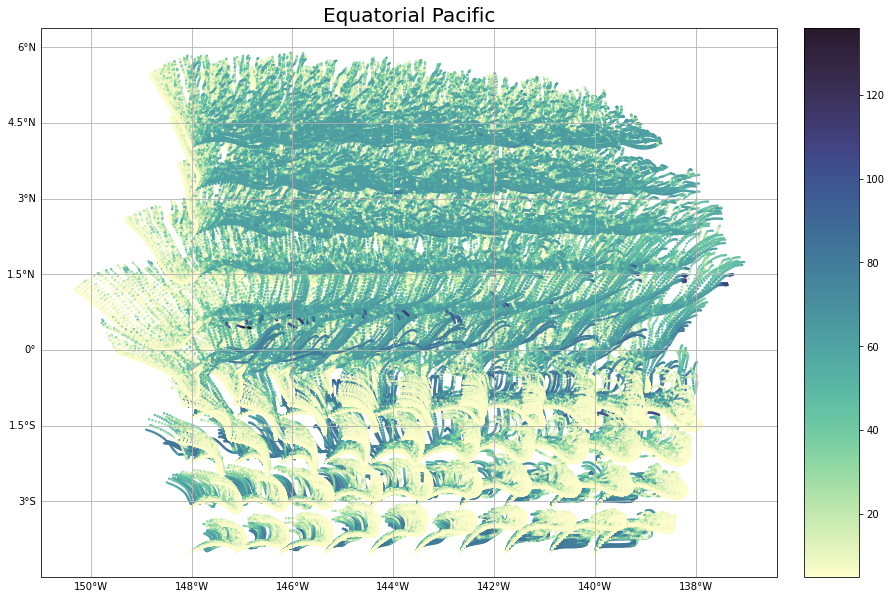

In [10]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(regions[region], fontsize=20)
sc =ax.scatter(ds['lon'],ds['lat'],c=ds['z'],cmap='cmo.deep',s=5, linewidth=0.2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([165,240,-15,15], crs=ccrs.PlateCarree())
# ax.set_ylim(np.mean(ds['lat'])-15,np.mean(ds['lat'])+15)
# ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-45+180,np.mean(ds['lon'].where(ds['lon']<0))+26+180)
# ax.set_xlim(np.mean(ds['lon'])-15,np.mean(ds['lon'])+30)
plt.colorbar(sc)
plt.show()

In [11]:
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [22]:
number_of_trajectories_to_plot = 1330
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 1330 of 10000 trajectories
plotting every 8 particles


In [13]:
mld = np.mean(np.divide(ds['z'],ds['mld']),axis=0)

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


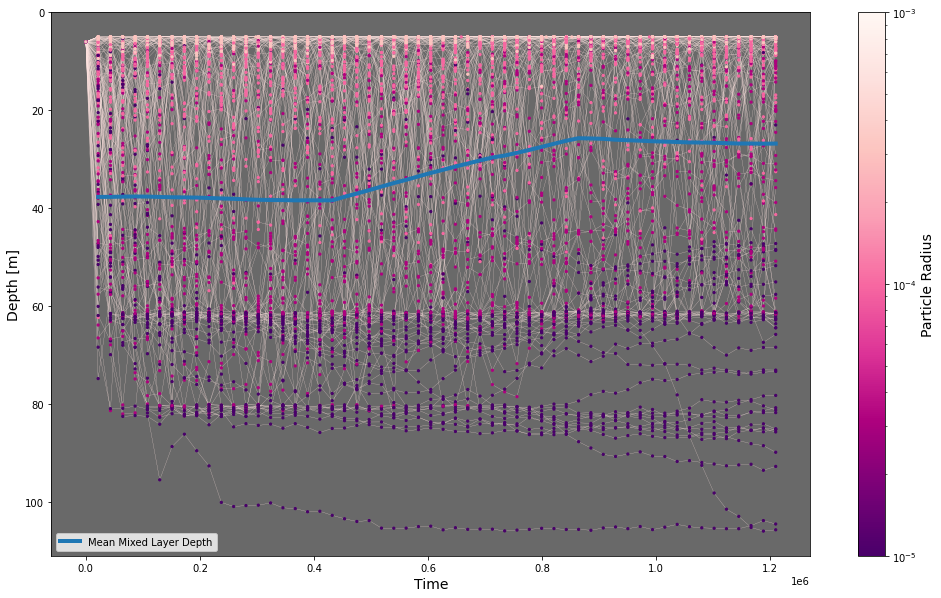

In [14]:
fig = plt.figure(figsize=(17,10))
ax = plt.axes()

sc = ax.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_facecolor('dimgray')
# ax.set_ylim(150,0)
ax.invert_yaxis()
ax.legend(loc = 'lower left')

cb = fig.colorbar(sc, ax=ax)
cb.set_label('Particle Radius', fontsize=14)

plt.show()

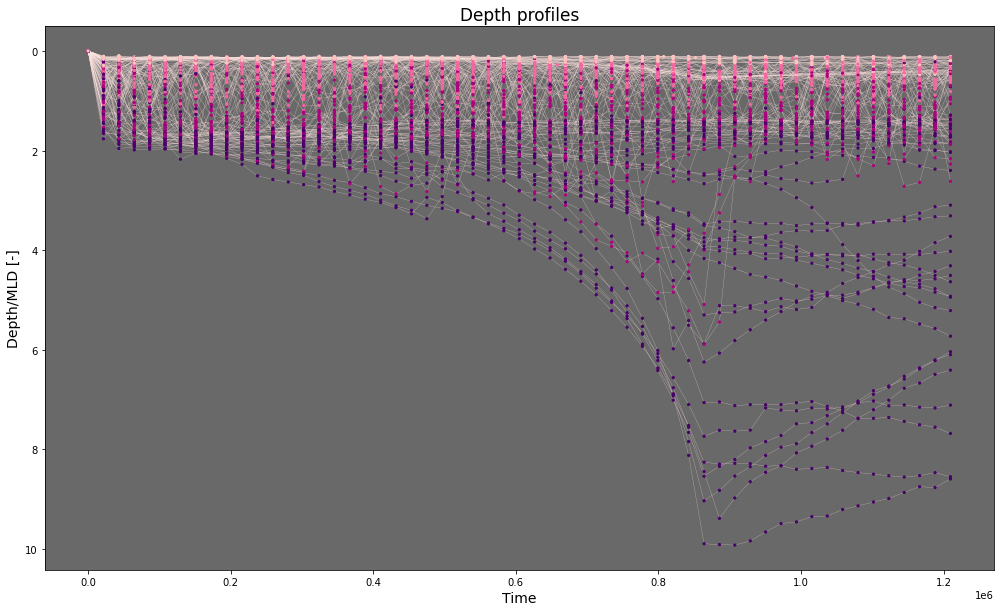

In [15]:
fig = plt.figure(figsize=(17,10))
ax = plt.axes()

sc = ax.scatter(ds['time'].T[:,::f_plt], ds['mld'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax.plot(ds['time'].T[:,::f_plt], ds['mld'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax.set_title('Depth profiles', fontsize=17)
ax.set_ylabel('Depth/MLD [-]', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.set_facecolor('dimgray')
# ax.set_ylim(150,0)
ax.invert_yaxis()

plt.show()

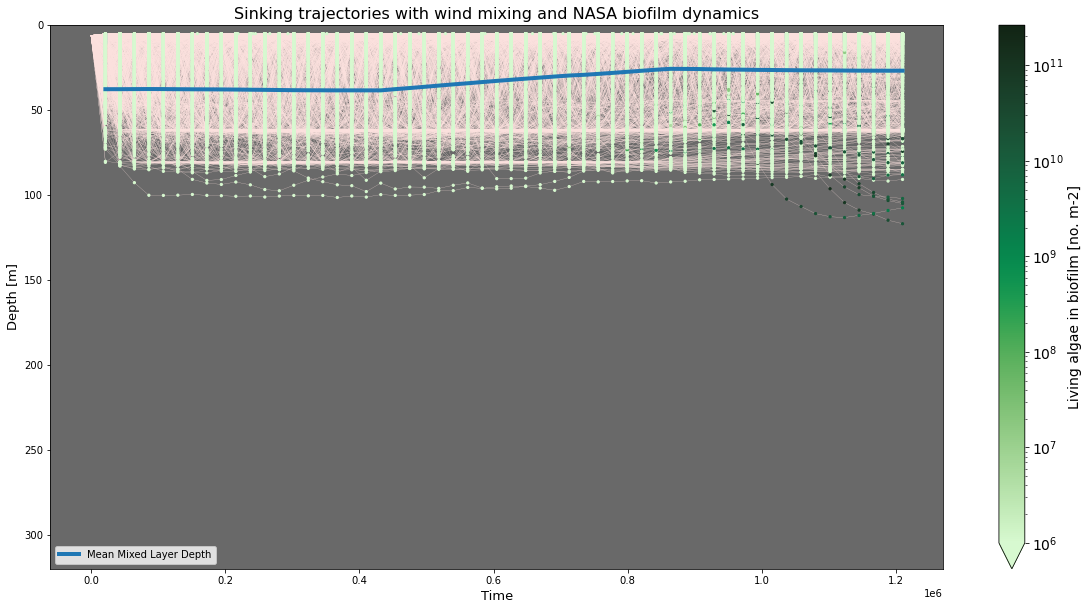

In [23]:
fig = plt.figure(figsize=(20,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=ds['a'].T[:,::f_plt],cmap='cmo.algae',norm=mcolors.LogNorm(vmin=max(ds['a'].min(), 1e2), vmax=ds['a'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and NASA biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(320,0)

cb = fig.colorbar(sc, ax=ax1, extend='min')
cb.set_label('Living algae in biofilm [no. m-2]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

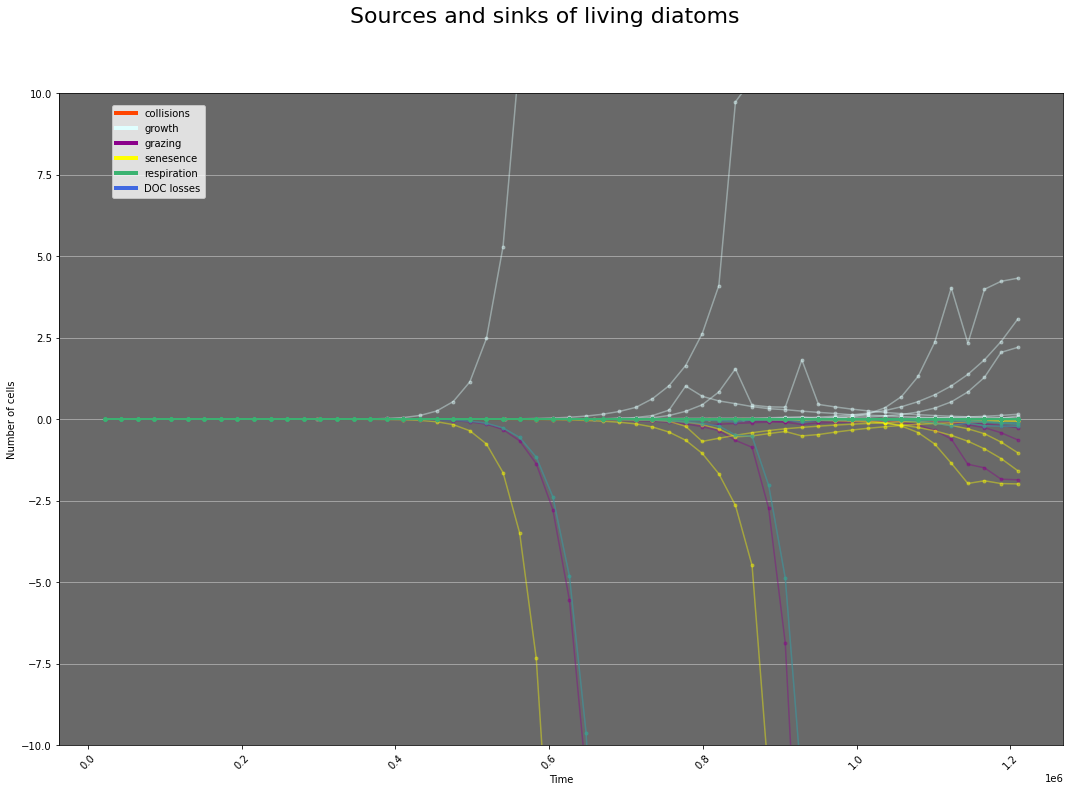

In [21]:
fig = plt.figure(figsize=(18,12))
fig.suptitle('Sources and sinks of living diatoms', fontsize=22)
ax = plt.axes()

ax.plot(ds['time'].T[1:,::f_plt], ds['a_gro'].T[1:,::f_plt], marker='o', markersize=3,c='lightcyan', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_coll'].T[1:,::f_plt], marker='o', markersize=3,c='orangered', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_graz'].T[1:,::f_plt], marker='o', markersize=3,c='darkmagenta', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_sen'].T[1:,::f_plt], marker='o', markersize=3,c='yellow', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_doc'].T[1:,::f_plt], marker='o', markersize=3,c='royalblue', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_resp'].T[1:,::f_plt], marker='o', markersize=3,c='mediumseagreen', alpha = 0.4)

ax.set_facecolor('dimgray')
ax.grid(b=True, axis='y')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-1e1,1e1)

custom_lines = [Line2D([0], [0], color='orangered', lw=4),
                Line2D([0], [0], color='lightcyan', lw=4),
                Line2D([0], [0], color='darkmagenta', lw=4),
                Line2D([0], [0], color='yellow', lw=4),
                Line2D([0], [0], color='mediumseagreen', lw=4),
                Line2D([0], [0], color='royalblue', lw=4)]

ax.legend(custom_lines, ["collisions", "growth", "grazing", "senesence", "respiration", "DOC losses"], bbox_to_anchor=(0.15, 0.99), loc='upper right')
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,12))
fig.suptitle('Sources and sinks of living diatoms', fontsize=22)
ax = plt.axes()

ax.plot(ds['time'].T[1:,::f_plt], ds['a_gro'].T[1:,::f_plt], marker='o', markersize=3,c='lightcyan', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_coll'].T[1:,::f_plt], marker='o', markersize=3,c='orangered', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_graz'].T[1:,::f_plt], marker='o', markersize=3,c='darkmagenta', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_sen'].T[1:,::f_plt], marker='o', markersize=3,c='yellow', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_doc'].T[1:,::f_plt], marker='o', markersize=3,c='royalblue', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_resp'].T[1:,::f_plt], marker='o', markersize=3,c='mediumseagreen', alpha = 0.4)

ax.set_facecolor('dimgray')
ax.grid(b=True, axis='y')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-1e7,1e7)

custom_lines = [Line2D([0], [0], color='orangered', lw=4),
                Line2D([0], [0], color='lightcyan', lw=4),
                Line2D([0], [0], color='darkmagenta', lw=4),
                Line2D([0], [0], color='yellow', lw=4),
                Line2D([0], [0], color='mediumseagreen', lw=4),
                Line2D([0], [0], color='royalblue', lw=4)]

ax.legend(custom_lines, ["collisions", "growth", "grazing", "senesence", "respiration", "DOC losses"], bbox_to_anchor=(0.15, 0.99), loc='upper right')
plt.show()

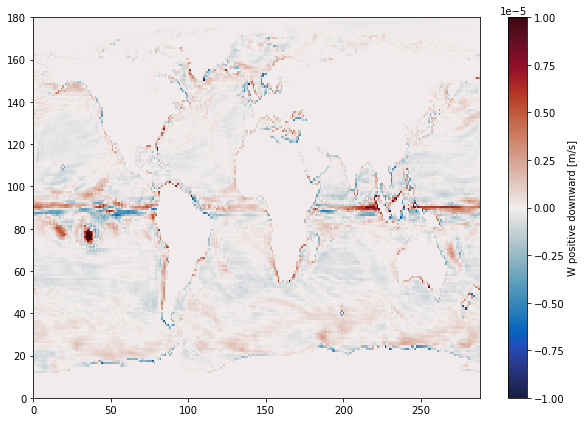

In [77]:
plt.figure(figsize=(10,7))
pc= plt.pcolormesh(fieldset.W.data[0,0],cmap='cmo.balance',vmin =-0.00001, vmax=0.00001)
plt.colorbar(pc,label='W positive downward [m/s]')

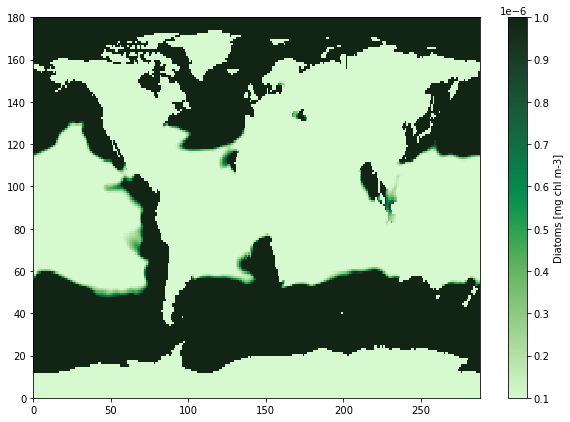

In [33]:
plt.figure(figsize=(10,7))
pc= plt.pcolormesh(fieldset.d_phy.data[0,0],cmap='cmo.algae',vmin=0.0000001, vmax=0.000001)
plt.colorbar(pc,label='Diatoms [mg chl m-3]')

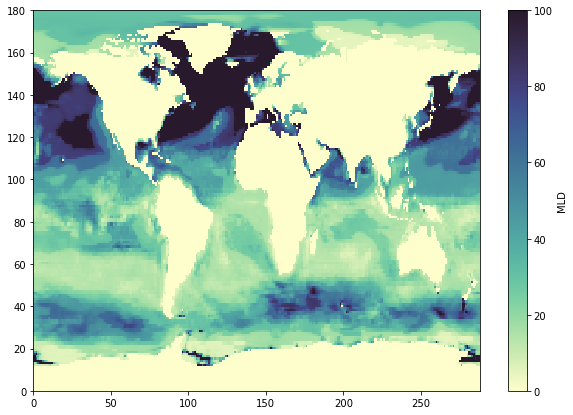

In [72]:
plt.figure(figsize=(10,7))
pc= plt.pcolormesh(fieldset.mldep.data[0],cmap='cmo.deep',vmax=100)
plt.colorbar(pc,label='MLD')

In [9]:
udata = xr.open_dataset(ufiles[0])

In [12]:
udata

<xarray.Dataset>
Dimensions:  (lato: 180, lato2: 180, lono: 288, lono2: 288, time: 1, zoc: 15)
Coordinates:
  * lono     (lono) float32 -179.375 -178.125 -176.875 ... 178.125 179.375
  * lono2    (lono2) float32 -178.75 -177.5 -176.25 ... 177.5 178.75 180.0
  * lato     (lato) float32 -90.0 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 90.0
  * lato2    (lato2) float32 -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
  * zoc      (zoc) float32 5.0 16.0 29.0 44.0 61.0 ... 205.0 234.0 270.0 315.0
  * time     (time) object 2004-01-03 12:00:00
Data variables:
    oxyp     (lato, lono) float32 ...
    temp     (time, zoc, lato, lono) float32 ...
    salt     (time, zoc, lato, lono) float32 ...
    u        (time, zoc, lato, lono) float32 ...
    v        (time, zoc, lato, lono) float32 ...
    w        (time, zoc, lato, lono) float32 ...
    kvert    (time, zoc, lato, lono) float32 ...
Attributes:
    xlabel:   Earobio3_hiAR6subdd (Historical AR6+obio: from Earobio3_piAR6(E...

In [23]:
udata['lato']

<xarray.DataArray 'lato' (lato: 180)>
array([-90. , -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
       -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
       -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
       -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
       -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5,
       -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5,
       -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,
        -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,
        20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,
        30.5,  31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,  49.5,
        50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5,
        60.5,  61.5,  62.5,  63.5,  64.5,  65.5,  66.5,  67.5,  68.5,  69.5,
        70.5,  71.5,  72.5,  73.5,  74.5,  75.5,  76.5,  77.5,  78.5,  79.5,
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  90. ],
      dtype=float32)
Coordinates:
  * lato     (lato) float32 -90.0 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 90.0
Attributes:
    units:    degrees_north

In [8]:
udata['lato2']

<xarray.DataArray 'lato2' (lato2: 180)>
array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80., -79.,
       -78., -77., -76., -75., -74., -73., -72., -71., -70., -69., -68., -67.,
       -66., -65., -64., -63., -62., -61., -60., -59., -58., -57., -56., -55.,
       -54., -53., -52., -51., -50., -49., -48., -47., -46., -45., -44., -43.,
       -42., -41., -40., -39., -38., -37., -36., -35., -34., -33., -32., -31.,
       -30., -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19.,
       -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,
        18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,
        42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,
        54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.],
      dtype=float32)
Coordinates:
  * lato2    (lato2) float32 -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
Attributes:
    units:    degrees_north

In [9]:
udata['lono']

<xarray.DataArray 'lono' (lono: 288)>
array([-179.375, -178.125, -176.875, ...,  176.875,  178.125,  179.375],
      dtype=float32)
Coordinates:
  * lono     (lono) float32 -179.375 -178.125 -176.875 ... 178.125 179.375
Attributes:
    units:    degrees_east

In [10]:
udata['lono2']

<xarray.DataArray 'lono2' (lono2: 288)>
array([-178.75, -177.5 , -176.25, ...,  177.5 ,  178.75,  180.  ],
      dtype=float32)
Coordinates:
  * lono2    (lono2) float32 -178.75 -177.5 -176.25 ... 177.5 178.75 180.0
Attributes:
    units:    degrees_east